In [1]:
import numpy as np
import pandas as pd
from src.policy.jas_voc_policy import JAS_voc_policy
from src.utils.mouselab_jas import MouselabJas
from src.utils.data_classes import Action, MouselabConfig
from src.utils.distributions import Normal
from src.utils.utils import sigma_to_tau
from src.utils.env_creation import create_tree, create_init
from simulation import run_simulation
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


%load_ext autoreload
%autoreload 2

In [3]:
num_projects = 5
num_criteria = 2
weights = [1]*2
expert_stds = [1]*3
expert_taus = sigma_to_tau(np.array(expert_stds))

mu = [3]*2
sigma = [1]*2

init = create_init([0]+(mu*num_projects), [0]+(sigma*num_projects))
expert_costs = [0.01]*3

config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=True)
env = MouselabJas(config=config)

Text(0.5, 1.0, 'distribution of expert guesses with sigma=1.52')

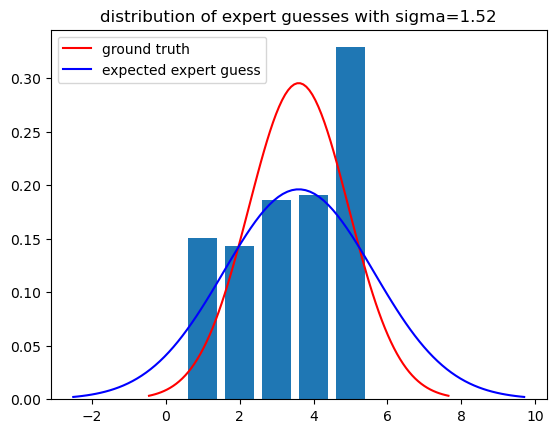

In [4]:
def plot_normal(mu, sigma, color, label):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color, label=label)

mu = 3.6
sigma = 1.35
expert_sigma = 1.52

plot_normal(mu, sigma, "r", "ground truth")
plot_normal(mu, np.sqrt(sigma**2+expert_sigma**2), "b", "expected expert guess")
probs = []
min_obs, max_obs = 1, 5
for obs in range(min_obs, max_obs+1):
    if obs == min_obs:
        probs.append(norm.cdf((obs+0.5), mu, np.sqrt(sigma**2+expert_sigma**2)))
    elif obs == max_obs:
        probs.append(1 - norm.cdf((obs-0.5), mu, np.sqrt(sigma**2+expert_sigma**2)))
    else:
        probs.append(norm.cdf((obs+0.5), mu, np.sqrt(sigma**2+expert_sigma**2)) - norm.cdf((obs-0.5), mu, np.sqrt(sigma**2+expert_sigma**2)))
plt.bar(range(min_obs, max_obs+1), probs)
plt.legend(loc="upper left")
plt.title("distribution of expert guesses with sigma=1.52")

In [3]:
init = create_init([0,4,3], [0, 0.000001, 1])
config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=True)
env = MouselabJas(config=config)

env.expert_truths = np.array([[1., 4., 5.], [1., 5., 5.]])
env.step(Action(0, 2))
env.step(Action(1, 2))

((0, Norm(4.00, 0.00), Norm(4.33, 0.58)), -0.01, False, 5.0)

In [21]:
policy_disc = JAS_voc_policy(discrete_observations=True)
env = MouselabJas(config=config)
actions = list(env.actions())
print([(action, policy_disc.myopic_voc_normal(env, action)) for action in actions])

[(Action(expert=0, query=1), 0.2325057193113349), (Action(expert=1, query=1), 0.2325057193113349), (Action(expert=0, query=2), 0.2325057193113349), (Action(expert=1, query=2), 0.2325057193113349), (Action(expert=2, query=3), 0)]


In [22]:
policy_cont = JAS_voc_policy(discrete_observations=False)
env = MouselabJas(config=config)
actions = list(env.actions())
print([(action, policy_cont.myopic_voc_normal(env, action)) for action in actions])

[(Action(expert=0, query=1), 0.3473637913683296), (Action(expert=1, query=1), 0.3473637913683296), (Action(expert=0, query=2), 0.3473637913683296), (Action(expert=1, query=2), 0.3473637913683296), (Action(expert=2, query=3), 0)]


In [23]:
action = Action(expert=1, query=1)
voc_disc = policy_disc.myopic_voc_normal(env, action)
voc_cont = policy_cont.myopic_voc_normal(env, action)
print(voc_disc, voc_cont)

0.2325057193113349 0.3473637913683296


In [5]:
voc_policy_disc_2 = JAS_voc_policy(discrete_observations=True, discrete_depth=2)
res_voc_disc2 = run_simulation(env, voc_policy_disc_2, start_seed=0, n=200)
res_voc_disc2.agg(["mean", "std"])

  2%|▏         | 3/200 [01:49<1:59:42, 36.46s/it]


KeyboardInterrupt: 

In [6]:
node_scale=1
value = 3
sample_sigma = 1
sigma = 1

probs = []
for obs in range(min_obs, max_obs+1):
    if obs == min_obs:
        probs.append(norm.cdf((obs+0.5)*node_scale, value, np.sqrt(sigma**2+sample_sigma**2)))
    elif obs == max_obs:
        probs.append(1 - norm.cdf((obs-0.5)*node_scale, value, np.sqrt(sigma**2+sample_sigma**2)))
    else:
        probs.append(norm.cdf((obs+0.5)*node_scale, value, np.sqrt(sigma**2+sample_sigma**2)) - norm.cdf((obs-0.5)*node_scale, value, np.sqrt(sigma**2+sample_sigma**2)))
print(probs)

[0.14442218317324246, 0.2174146217426391, 0.2763263901682369, 0.21741462174263915, 0.1444221831732424]


In [8]:
eval_points = [obs+0.5 for obs in range(min_obs, max_obs)]
cdf_points = np.array([0] + [norm.cdf((obs)*node_scale, value, np.sqrt(sigma**2+sample_sigma**2)) for obs in eval_points] + [1])
probs = cdf_points[1:] - cdf_points[:-1]
print(probs)

[0.14442218 0.21741462 0.27632639 0.21741462 0.14442218]


In [5]:
def compare(config, n=100, seed=0):
    env = MouselabJas(config=config)
    voc_policy_disc = JAS_voc_policy(discrete_observations=True)
    voc_policy_disc_1 = JAS_voc_policy(discrete_observations=True, discrete_depth=1)
    voc_policy_disc_2 = JAS_voc_policy(discrete_observations=True, discrete_depth=2)
    voc_policy = JAS_voc_policy(discrete_observations=False)
    res_voc = run_simulation(env, voc_policy, start_seed=seed, n=n)
    res_voc["algorithm"] = "MGPO_cont"
    res_voc_disc = run_simulation(env, voc_policy_disc, start_seed=seed, n=n)
    res_voc_disc["algorithm"] = "MGPO_disc_old"
    res_voc_disc1 = run_simulation(env, voc_policy_disc_1, start_seed=seed, n=n)
    res_voc_disc1["algorithm"] = "MGPO_disc_d1"
    res_voc_disc2 = run_simulation(env, voc_policy_disc_2, start_seed=seed, n=n)
    res_voc_disc2["algorithm"] = "MGPO_disc_d2"
    res = pd.concat([res_voc, res_voc_disc, res_voc_disc1, res_voc_disc2])
    return res

In [8]:
res = compare(config, 1000)
res.groupby("algorithm").agg(["mean", "std"])

100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]


reward           actions             seed              \
                   mean       std    mean       std   mean         std   
algorithm                                                                
MGPO_cont      3.370110  0.533895   4.039  0.906808  499.5  288.819436   
MGPO_disc_d1   3.370650  0.477755   3.535  1.196749  499.5  288.819436   
MGPO_disc_d2   3.379887  0.509375   4.128  0.915672  499.5  288.819436   
MGPO_disc_old  3.362863  0.486294   3.547  1.181180  499.5  288.819436   

                runtime           true_reward           expected_reward  \
                   mean       std        mean       std            mean   
algorithm                                                                 
MGPO_cont      0.006938  0.007861    3.404673  0.877255        3.370110   
MGPO_disc_d1   0.011344  0.007705    3.386066  0.891472        3.370650   
MGPO_disc_d2   0.197094  0.036040    3.403610  0.875400        3.379887   
MGPO_disc_old  0.012859  0.007192    3.388275  0.893435        3.362863   

                         
                    std  
algorithm                
MGPO_cont      0.533895  
MGPO_disc_d1   0.477755  
MGPO_disc_d2   0.509375  
MGPO_disc_old  0.486294

In [10]:
res.groupby("algorithm").agg(["mean", "std"])[["expected_reward", "true_reward"]]

expected_reward           true_reward          
                         mean       std        mean       std
algorithm                                                    
MGPO_cont            3.370110  0.533895    3.404673  0.877255
MGPO_disc_d1         3.370650  0.477755    3.386066  0.891472
MGPO_disc_d2         3.379887  0.509375    3.403610  0.875400
MGPO_disc_old        3.362863  0.486294    3.388275  0.893435

In [ ]:
# Number of projects:
num_projects = [(40+12+22)/3, 7, 50, 25, 27, 27, 10, 24, 4, 4, 37, (20+50+150+250)/4, 4,2,5,400,2,12, (10+30)/2, 6, (5+30)/2, (1000+200)/2, 3, (5+30)/2, 8, 6, 10,
    4, 5, 20, 14, (60+50)/2, 3, 18, 6, 37, 14, 6, (2+3)/2, 20, 20, 4, 20, 14, 5, 20, 20, 5, 45, 1500, 6, 5, 60, 10, 50, 6, 5, 100, 5, 4]
print("Mean", np.mean(num_projects))
print("Median", np.median(num_projects))

Mean 59.64444444444445
Median 13.0


In [ ]:
papers_with_criteria = 66
num_papers = [3, 10, 5, 5, 9, 28, 41, 48, 9, 20, 3, 38, 38, 17, 21, 21, 7, 12, 16, 9, 4, 15, 40]
mean_criteria = np.sum(num_papers)/papers_with_criteria
print("Mean", mean_criteria)
top_criteria = np.argsort(num_papers)+1
print(list(top_criteria)[-10:][::-1])

utilized_in_half = [7,8,12,13,23]

Mean 6.348484848484849
[8, 7, 23, 13, 12, 6, 16, 15, 10, 14]


In [ ]:
electric_criteria = [13, 17, 12, 4]
it_criteria = [5, 7, 49, 15, 5]
pharmaceutical_criteria = [4]


In [ ]:
# Domains
domains = ["Eletronic/Electricity and Chemical", "Textile", "Aerospacial", "Spacial", "Chemical", "Chemical", 
    "Eletronic/Electricity", "Industrial", "Non-Specified", "Non-Specified", "Metallurgy", "Eletronic/Electricity",
    "Non-Specified", "Non-Specified", "Biotechnology", "Automotive", "Information Technology", "Industrial", "Industrial"
    "Research", "Pharmaceutical", "Non-Specified", "Metallurgy", "Pharmaceutical", "Non-Specified", "Information Technology",
    "Information Technology", "Telecommunications", "Non-Specified", "Non-Specified", "Nuclear", "Pharmaceutical", "Non-Specified",
    "Non-Specified", "Industrial", "Non-Specified", "Metallurgy", "Eletronic/Electricity", "Non-Specified", "Government Sponsored"
    "Civil, Mechanical, and others", "Non-Specified", "Pharmaceutical", "Pharmaceutical", "Manufacturing", "Non-Specified",
    "Pharmaceutical", "Information Technology", "Civil, Mechanical, and others", "Pharmaceutical", "Non-Specified", "Eletronic/Electricity",
    "Agriculture, Innovation, Textile and others", "Private/Public Sector", "Non-Specified", "Non-Specified", "Eletronic/Electricity",
    "Government Sponsored", "Non-Specified", "Pharmaceutical", "Private/Public Sector", "Energy", "Military", "Innovation",
    "Electricity/Mechanical/Telecommunications/IT", "Non-Specified"]

from collections import Counter

counter = Counter(domains)
counter.most_common()


[('Non-Specified', 19),
 ('Pharmaceutical', 8),
 ('Eletronic/Electricity', 5),
 ('Information Technology', 4),
 ('Industrial', 3),
 ('Metallurgy', 3),
 ('Chemical', 2),
 ('Private/Public Sector', 2),
 ('Eletronic/Electricity and Chemical', 1),
 ('Textile', 1),
 ('Aerospacial', 1),
 ('Spacial', 1),
 ('Biotechnology', 1),
 ('Automotive', 1),
 ('IndustrialResearch', 1),
 ('Telecommunications', 1),
 ('Nuclear', 1),
 ('Government SponsoredCivil, Mechanical, and others', 1),
 ('Manufacturing', 1),
 ('Civil, Mechanical, and others', 1),
 ('Agriculture, Innovation, Textile and others', 1),
 ('Government Sponsored', 1),
 ('Energy', 1),
 ('Military', 1),
 ('Innovation', 1),
 ('Electricity/Mechanical/Telecommunications/IT', 1)]

In [ ]:
def diff_rec(str1, str2):
    if (len(str1) == 0) and (len(str2) == 0):
        return 0
    elif len(str1) == 0:
        return sum([ord(c) for c in str2])
    elif len(str2) == 0: 
        return sum([ord(c) for c in str1])
    elif str1[0] == str2[0]:
        return diff_rec(str1[1:], str2[1:])
    else:
        diff1 = ord(str1[0]) + diff_rec(str1[1:], str2)
        diff2 = ord(str2[0]) + diff_rec(str1, str2[1:])
        return min(diff1, diff2)

print(diff_rec("through", "trouf"))

413
